# Training models

This notebook shows how to train a pass success model using XGBoost.

In [1]:
from pathlib import Path
from functools import partial

import matplotlib.pyplot as plt

import mlflow
from xgboost import XGBClassifier

/home/toc3/anaconda3/lib/python3.7/site-packages/requests/__init__.py:114: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4)/charset_normalizer (3.2.0) doesn't match a supported version!
  RequestsDependencyWarning,


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import tqdm
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

In [4]:
from unxpass.databases import SQLiteDatabase
from unxpass.datasets import PassesDataset
from unxpass.components import pass_success
from unxpass.components.utils import log_model, load_model
from unxpass.visualization import plot_action

/home/toc3/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load dataset

We assume you've already generated a training and test with all required features and labels. If not, you can do this from the command line with:

```
unxpass create-dataset \
  sqlite://$(pwd)/stores/database.sqlite \
  $(pwd)/stores/datasets/default/train \
  $(pwd)/config/dataset/train.yaml
```

```
unxpass create-dataset \
  sqlite://$(pwd)/stores/database.sqlite \
  $(pwd)/stores/datasets/default/test \
  $(pwd)/config/dataset/test.yaml
```

Alternatively, the notebook titled "2-computing-and-storing-features" explains how to do this using the API.

In [5]:
train_DB_PATH = Path("../stores/train-database.sqlite")
train_db = SQLiteDatabase(train_DB_PATH)

test_DB_PATH = Path("../stores/test-database.sqlite")
test_db = SQLiteDatabase(test_DB_PATH)

In [6]:
STORES_FP = Path("../stores")

dataset_train = partial(PassesDataset, path=STORES_FP / "datasets" / "default" / "train")
dataset_test = partial(PassesDataset, path=STORES_FP / "datasets" / "default" / "test")

## Configure model

Now we have to define the hyperparameters of the XGBoost model and the features to use. The features should be specified as a dictionary, where the key is the name of the feature generator and the values are the features that should be included (a generator can generate multiple features). The docstring of each feature generator provides details about the features it generates. Note that the suffix "a0" indicates that a feature is computed for the pass action, "a1" is the action before the pass, and so on.

In [7]:
import unxpass
print(unxpass.features.movement.__doc__)

Get the distance covered by each action.

    Parameters
    ----------
    actions : SPADLActions
        The actions of a game.

    Returns
    -------
    Features
        The horizontal ('dx'), vertical ('dy') and total ('movement') distance
        covered by each action.
    


In [8]:
model = pass_success.XGBoostComponent(
    model=XGBClassifier(
        objective="binary:logistic", 
        eval_metric="auc"
        # you probably want to do some hyperparameter tuning here to get a good model
    ),
    features={
        'startpolar': [
            'start_dist_to_goal_a0',
            'start_angle_to_goal_a0'
        ],
        'relative_startlocation': [
            'start_dist_goalline_a0',
            'start_dist_sideline_a0'
        ],
        'endpolar': [
            'end_dist_to_goal_a0',
            'end_angle_to_goal_a0'
        ],
        'relative_endlocation': [
            'end_dist_goalline_a0',
            'end_dist_sideline_a0'
        ],
        'movement': [
            'movement_a0',
            'dx_a0',
            'dy_a0'
        ],
        'angle': [
            'angle_a0'
        ],
        'ball_height_onehot': [
            'ball_height_ground_a0',
            'ball_height_low_a0',
            'ball_height_high_a0'
        ],
        'player_possession_time': [
            'player_possession_time_a0'
        ],
        'speed': [
            'speed_a01',
            'speed_a02'
        ],
        'under_pressure': [
            'under_pressure_a0'
        ],
        'dist_defender': [
            'dist_defender_start_a0',
            'dist_defender_end_a0',
            'dist_defender_action_a0'
        ],
        'nb_opp_in_path': [
            'nb_opp_in_path_a0'
        ]
    }, 
)

## Train and test model

In [9]:
model.train(dataset_train)

[10/12/23 20:04:11] INFO     Fitting model on train set                                             ]8;id=625703;file:///home/toc3/anaconda3/lib/python3.7/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=30804;file:///home/toc3/anaconda3/lib/python3.7/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\

[0]	validation_0-auc:0.91531
[1]	validation_0-auc:0.92219
[2]	validation_0-auc:0.92628
[3]	validation_0-auc:0.92697
[4]	validation_0-auc:0.92950
[5]	validation_0-auc:0.92945
[6]	validation_0-auc:0.93066
[7]	validation_0-auc:0.93118
[8]	validation_0-auc:0.93185
[9]	validation_0-auc:0.93208
[10]	validation_0-auc:0.93274
[11]	validation_0-auc:0.93323
[12]	validation_0-auc:0.93400
[13]	validation_0-auc:0.93463
[14]	validation_0-auc:0.93469
[15]	validation_0-auc:0.93462
[16]	validation_0-auc:0.93438
[17]	validation_0-auc:0.93431
[18]	validation_0-auc:0.93414
[19]	validation_0-auc:0.93400
[20]	validation_0-auc:0.93421
[21]	validation_0-auc:0.93412
[22]	validation_0-auc:0.93427
[23]	validation_0-auc:0.93445
[24]	validation_0-auc:0.93442
[25]	validation_0-auc:0.93442
[26]	validation_0-auc:0.93459
[27]	validation_0-auc:0.93460
[28]	validation_0-auc:0.93446
[29]	validation_0-auc:0.93397
[30]	validation_0-auc:0.93376
[31]	validation_0-auc:0.93379
[32]	validation_0-auc:0.93376
[33]	validation_0-au

In [10]:
# You can now log the model in the MLFflow registry
mlflow.set_experiment(experiment_name="pass_success/threesixty")
modelinfo = log_model(model, artifact_path="component")
print(f"Model saved as {modelinfo.model_uri}")

Model saved as runs:/fbac0a8ab8f346d3bdec0e0e84955889/component


In [12]:
# Then you can reload it later
model = load_model("runs:/fbac0a8ab8f346d3bdec0e0e84955889/component")

In [13]:
# Next, evaluate how the model performs on a test set
model.test(dataset_test)

ValueError: could not determine the shape of object type 'DataFrame'

## Making predictions

Once trained, the model can be used to estimate the success probability of each pass in a dataset.

In [14]:
p_success = model.predict(dataset_test)
p_success

game_id  action_id
3788745  0            0.995611
         18           0.960465
         23           0.997749
         25           0.978927
         29           0.997556
                        ...   
3869685  2543         0.921209
         2555         0.998061
         2557         0.980433
         2564         0.983159
         2566         0.944922
Length: 9069, dtype: float32

Let's visualize what a pass what a high and a low success probability look like.

away_idx :  True
away_idx :  True


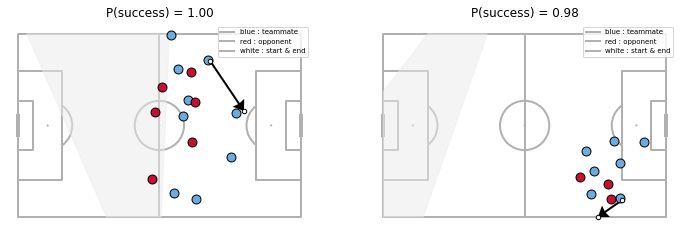

In [16]:
easy_pass, hard_pass = (3795506, 4), (3795506, 2791)
df_actions = test_db.actions(game_id=3795506)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_action(df_actions.loc[easy_pass], ax=ax[0])
ax[0].set_title(f"P(success) = {p_success.loc[easy_pass]:.2f}")
plot_action(df_actions.loc[hard_pass], ax=ax[1])
ax[1].set_title(f"P(success) = {p_success.loc[hard_pass]:.2f}")
plt.show()

Instead of predicting the success probability of the actual pass, we can also estimate the success probability of a pass towards every other location on the  pitch.

In [18]:
p_success_surfaces = model.predict_surface(dataset_test, game_id=3795506, db=test_db, x_bins=104, y_bins=68)

Output()

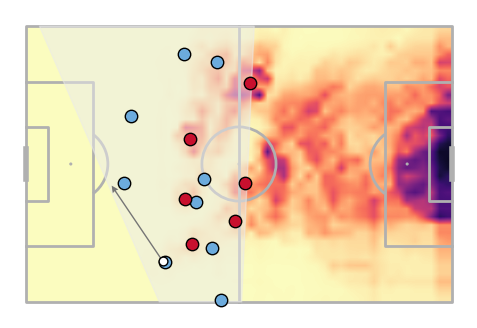

In [ ]:
df_actions = test_db.actions(game_id=3795506)
sample = (3795506, 4)

fig, ax = plt.subplots(1, 1, figsize=(6,4))
plot_action(df_actions.loc[sample], surface=p_success_surfaces[f"action_{sample[1]}"], ax=ax, surface_kwargs={"cmap": "magma", "vmin": 0, "vmax": 1, "interpolation": "bilinear"})
plt.show()

In [ ]:
db.close()